# NFL Potential Trade Analysis

### Chris Haleas and Andrew Eby

## Preprocessing Data

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 

# Load the data from the CSV file
df = pd.read_csv("/kaggle/input/nfl-stats-1999-2022/yearly_player_data.csv")

# Filter players who have played more than 8 games
df_significant_players = df[df['games'] >= 8]

# Separate by position
quarter_backs = df_significant_players[df_significant_players['position'] == 'QB']
running_backs = df_significant_players[df_significant_players['position'] == 'RB']
wide_receivers = df_significant_players[df_significant_players['position'] == 'WR']
tight_ends = df_significant_players[df_significant_players['position'] == 'TE']

# Features for each position
qb_features = ['pass_td_pct', 'ypa', 'comp_pct', 'pass_ypg', 'passing_yards', 'passing_air_yards']
rb_features = ['rush_td_pct', 'ypc', 'yptouch', 'rush_ypg', 'rushing_yards', 'receptions']
wr_features = ['rec_td_pct', 'ypr', 'target_share', 'air_yards_share', 'targets', 'receptions', 'receiving_yards']
te_features = ['rec_td_pct', 'ypr', 'target_share', 'air_yards_share', 'targets', 'receptions', 'receiving_yards']

# Scale Features
scaler = MinMaxScaler()

# For Quarterbacks
quarter_backs[qb_features] = scaler.fit_transform(quarter_backs[qb_features])
quarter_backs['position_score'] = quarter_backs[qb_features].mean(axis=1)

# For Running Backs
running_backs[rb_features] = scaler.fit_transform(running_backs[rb_features])
running_backs['position_score'] = running_backs[rb_features].mean(axis=1)

# For Wide Receivers
wide_receivers[wr_features] = scaler.fit_transform(wide_receivers[wr_features])
wide_receivers['position_score'] = wide_receivers[wr_features].mean(axis=1)

# For Tight Ends
tight_ends[te_features] = scaler.fit_transform(tight_ends[te_features])
tight_ends['position_score'] = tight_ends[te_features].mean(axis=1)

all_positions = pd.concat([quarter_backs, running_backs, wide_receivers, tight_ends])

average_scores = all_positions.groupby(['season', 'team', 'position'])['position_score'].mean().reset_index()

average_scores.rename(columns={
    'season': 'year',
    'position_score': 'average_position_score_perteam'
}, inplace=True)

print(average_scores.head(1500))



      year team position  average_position_score_perteam
0     2012  ARI       RB                        0.204128
1     2012  ARI       TE                        0.191214
2     2012  ARI       WR                        0.337462
3     2012  ATL       QB                        0.749261
4     2012  ATL       RB                        0.262522
...    ...  ...      ...                             ...
1449  2023  TEN       WR                        0.254745
1450  2023  WAS       QB                        0.590650
1451  2023  WAS       RB                        0.292592
1452  2023  WAS       TE                        0.253602
1453  2023  WAS       WR                        0.302130

[1454 rows x 4 columns]


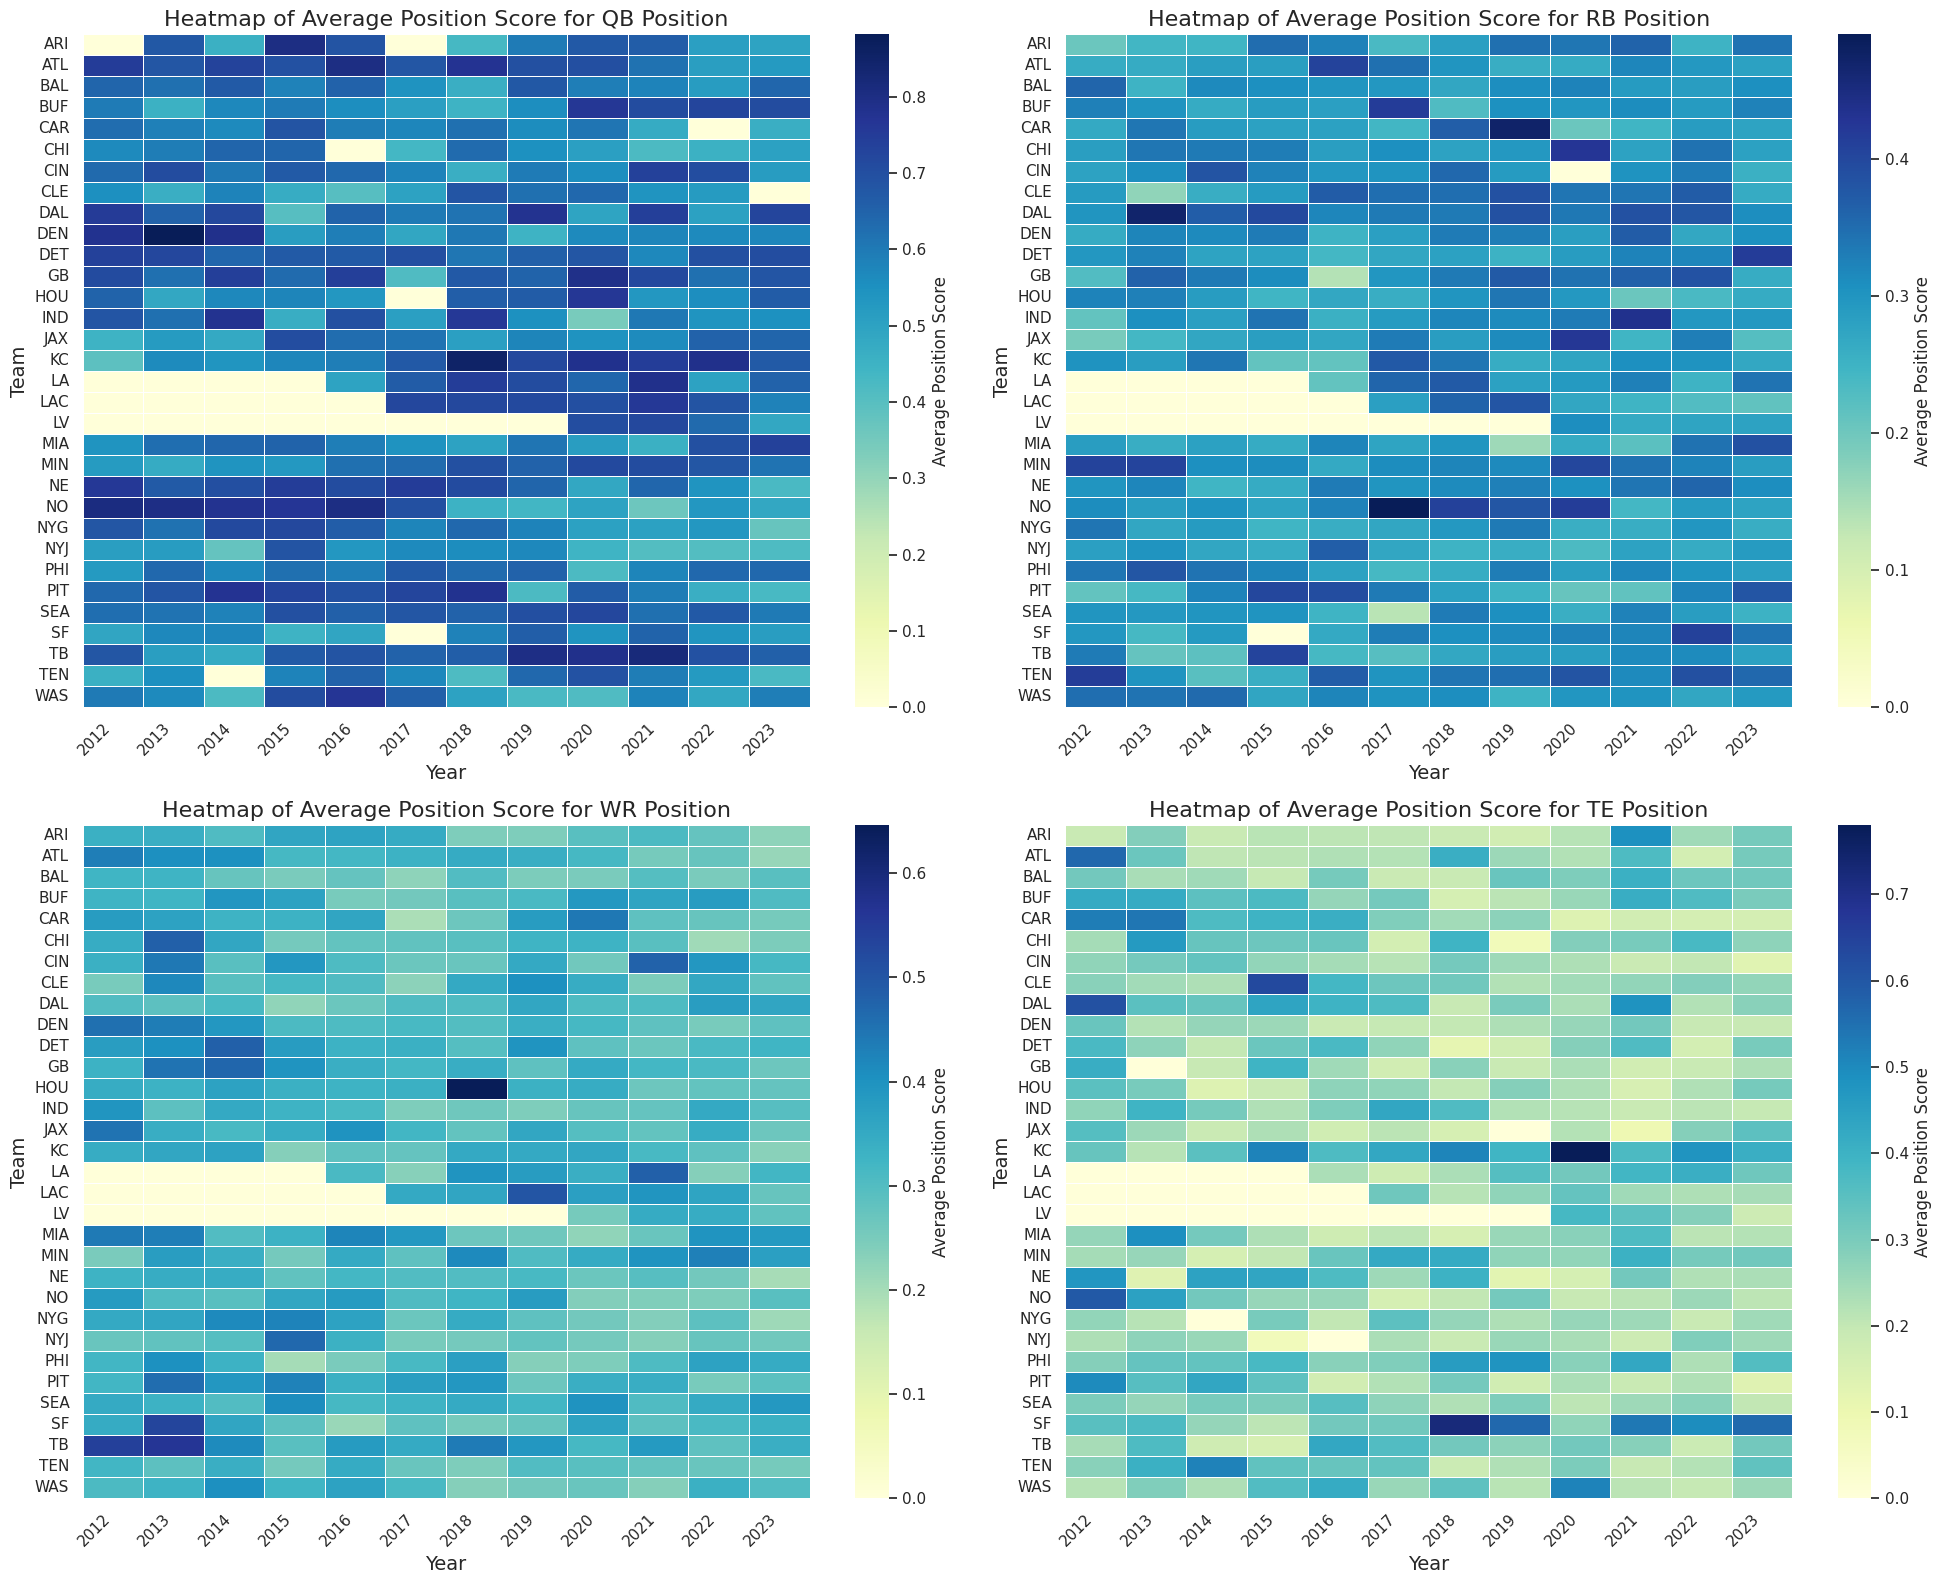

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

positions = ['QB', 'RB', 'WR', 'TE']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

all_teams = sorted(df['team'].unique())
all_years = sorted(df['season'].unique())

for i, position in enumerate(positions):
    position_data = average_scores[average_scores['position'] == position]
    
    heatmap_data = position_data.pivot_table(index='team', columns='year', values='average_position_score_perteam')
    
    heatmap_data = heatmap_data.reindex(index=all_teams, columns=all_years)
    
    heatmap_data = heatmap_data.fillna(0)

    ax = axes[i // 2, i % 2]
    
    sns.heatmap(heatmap_data, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Average Position Score'}, 
                linewidths=0.5, ax=ax, cbar=True)
    
    ax.set_title(f'Heatmap of Average Position Score for {position} Position', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Team', fontsize=14)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.show()


In [25]:
quarter_backs['distance'] = np.linalg.norm(quarter_backs[['avg_scaled_score', 'passing_yards']].values, axis=1)
running_backs['distance'] = np.linalg.norm(running_backs[['avg_scaled_score', 'rushing_yards']].values, axis=1)
wide_receivers['distance'] = np.linalg.norm(wide_receivers[['avg_scaled_score', 'receiving_yards']].values, axis=1)
tight_ends['distance'] = np.linalg.norm(tight_ends[['avg_scaled_score', 'receiving_yards']].values, axis=1)


grades = ['F', 'D', 'C', 'B', 'A', 'S']

for df in [quarter_backs, running_backs, wide_receivers, tight_ends]:
    max_distance = np.max(df['distance'])
    min_distance = np.min(df['distance'])
    
    bins = np.linspace(min_distance, max_distance, 7)
    
    df['grade'] = pd.cut(df['distance'], bins=bins, labels=grades, include_lowest=True, right=False)

grade_colors = {'S': 'brown', 'A': 'green', 'B': 'blue', 'C': 'orange', 'D': 'purple', 'F': 'red'}

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot for each position
for ax, (df, position, y_feature) in zip(axs.flatten(), 
                                          [(quarter_backs, 'Quarterbacks', 'passing_yards'),
                                           (running_backs, 'Running Backs', 'rushing_yards'),
                                           (wide_receivers, 'Wide Receivers', 'receiving_yards'),
                                           (tight_ends, 'Tight Ends', 'receiving_yards')]):
    
    for grade, color in grade_colors.items():
        subset = df[df['grade'] == grade]
        ax.scatter(
            subset['avg_scaled_score'], 
            subset[y_feature], 
            c=color, 
            label=grade,
            alpha=0.6,  
            s=30  
        )

    ax.set_xlabel('Average Scaled Score')
    ax.set_ylabel(y_feature)
    ax.set_title(f'{position} - Average Scaled Score vs {y_feature}')
    ax.legend(title='Grades')

plt.tight_layout()
plt.show()


KeyError: "['avg_scaled_score'] not in index"

In [26]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Assuming the data loading and preprocessing steps remain the same
# ...

# Create a function to prepare data for regression
def prepare_regression_data(df):
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df = df.sort_values(['team', 'position', 'year'])
    df['prev_year_score'] = df.groupby(['team', 'position'])['average_position_score_perteam'].shift(1)
    df['2_year_ago_score'] = df.groupby(['team', 'position'])['average_position_score_perteam'].shift(2)
    df['improved'] = (df['average_position_score_perteam'] > df['prev_year_score']).astype(int)
    df = df.dropna()
    return df

# Prepare the data
regression_data = prepare_regression_data(average_scores)

# Split features and target
X = regression_data[['prev_year_score', '2_year_ago_score']]
y = regression_data['improved']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Function to project future performance
def project_future_performance(team, position, last_year, last_year_score, two_years_ago_score, num_years=5):
    future_years = pd.date_range(start=str(last_year+1), periods=num_years, freq='Y')
    future_data = pd.DataFrame({
        'year': future_years,
        'prev_year_score': [last_year_score] + [None]*(num_years-1),
        '2_year_ago_score': [two_years_ago_score] + [None]*(num_years-1)
    })
    
    predictions = []
    for i in range(num_years):
        prob = model.predict_proba(future_data.iloc[[i]][['prev_year_score', '2_year_ago_score']])[0][1]
        predictions.append(prob)
        if i < num_years - 1:
            future_data.loc[i+1, '2_year_ago_score'] = future_data.loc[i, 'prev_year_score']
            future_data.loc[i+1, 'prev_year_score'] = last_year_score * (1 + (prob - 0.5) * 0.1)  # Adjust score based on probability
    
    return future_data['year'], predictions

# Function to simulate adding a player
def simulate_player_addition(team, position, player_name, player_score, last_year, last_year_score, two_years_ago_score):
    # Current trajectory
    current_years, current_predictions = project_future_performance(team, position, last_year, last_year_score, two_years_ago_score)
    
    # New trajectory with added player
    new_last_year_score = (last_year_score + player_score) / 2
    new_years, new_predictions = project_future_performance(team, position, last_year, new_last_year_score, two_years_ago_score)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(current_years, current_predictions, marker='o', label='Current Trajectory')
    plt.plot(new_years, new_predictions, marker='s', label=f'With {player_name}')
    plt.title(f'Projected Improvement Probability for {team} - {position}')
    plt.xlabel('Year')
    plt.ylabel('Probability of Improvement')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Function to get player's 2023 stats
def get_player_2023_stats(player_name, position):
    player_data = all_positions[(all_positions['player'] == player_name) & 
                                (all_positions['position'] == position) & 
                                (all_positions['season'] == 2023)]
    if player_data.empty:
        print(f"No 2023 data found for {player_name}")
        return None
    return player_data['position_score'].values[0]

# User input function
def get_user_input():
    team = input("Enter the team (e.g., NE): ").upper()
    position = input("Enter the position (QB, RB, WR, or TE): ").upper()
    player_name = input("Enter the player name to add: ")
    return team, position, player_name

# Main execution
team, position, player_name = get_user_input()

last_year_data = regression_data[(regression_data['team'] == team) & 
                                 (regression_data['position'] == position) & 
                                 (regression_data['year'].dt.year == regression_data['year'].dt.year.max())]

if not last_year_data.empty:
    last_year = last_year_data['year'].dt.year.values[0]
    last_year_score = last_year_data['average_position_score_perteam'].values[0]
    two_years_ago_score = last_year_data['prev_year_score'].values[0]
    
    player_score = get_player_2023_stats(player_name, position)
    
    if player_score is not None:
        simulate_player_addition(team, position, player_name, player_score, last_year, last_year_score, two_years_ago_score)
    else:
        print("Unable to simulate player addition due to missing data.")
else:
    print(f"No data found for {team} - {position}")

Model Accuracy: 0.6541666666666667

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       119
           1       0.67      0.63      0.65       121

    accuracy                           0.65       240
   macro avg       0.65      0.65      0.65       240
weighted avg       0.65      0.65      0.65       240



Enter the team (e.g., NE):  NE
Enter the position (QB, RB, WR, or TE):  QB
Enter the player name to add:  patrick mahomes


KeyError: 'player'

In [38]:
qb_features = ['pass_td_pct', 'ypa', 'comp_pct', 'pass_ypg', 'passing_yards', 'passing_air_yards']
rb_features = ['rush_td_pct', 'ypc', 'yptouch', 'rush_ypg', 'rushing_yards', 'receptions']
wr_features = ['rec_td_pct', 'ypr', 'target_share', 'air_yards_share', 'targets', 'receptions', 'receiving_yards']
te_features = ['rec_td_pct', 'ypr', 'target_share', 'air_yards_share', 'targets', 'receptions', 'receiving_yards']

# Scale Features
scaler = MinMaxScaler()

# For Quarterbacks
quarter_backs[qb_features] = scaler.fit_transform(quarter_backs[qb_features])
quarter_backs['position_score'] = quarter_backs[qb_features].mean(axis=1)

# For Running Backs
running_backs[rb_features] = scaler.fit_transform(running_backs[rb_features])
running_backs['position_score'] = running_backs[rb_features].mean(axis=1)

# For Wide Receivers
wide_receivers[wr_features] = scaler.fit_transform(wide_receivers[wr_features])
wide_receivers['position_score'] = wide_receivers[wr_features].mean(axis=1)

# For Tight Ends
tight_ends[te_features] = scaler.fit_transform(tight_ends[te_features])
tight_ends['position_score'] = tight_ends[te_features].mean(axis=1)

# Concatenate all positions and retain player-level data
all_positions = pd.concat([quarter_backs, running_backs, wide_receivers, tight_ends])

print(all_positions[['player_name', 'team', 'position', 'season', 'position_score']].head(10))

# ---- TRADE EVALUATION ----
team_avg_scores = all_positions.groupby(['season', 'team', 'position'])['position_score'].mean().reset_index()
team_avg_scores.rename(columns={'position_score': 'team_avg_position_score'}, inplace=True)
player_name = input("Enter the player's name: ")
current_team_name = input("Enter the player's current team (for reference, not used in comparison): ")
trade_team_name = input("Enter the potential trade team's name: ")
season = int(input("Enter the season year (e.g., 2021): "))

player_data = all_positions[(all_positions['player_name'] == player_name) & (all_positions['season'] == season)]

if not player_data.empty:
    player_position_score = player_data['position_score'].values[0]
    player_position = player_data['position'].values[0]

    trade_team_data = team_avg_scores[(team_avg_scores['team'] == trade_team_name) & 
                                      (team_avg_scores['season'] == season) & 
                                      (team_avg_scores['position'] == player_position)]

    if not trade_team_data.empty:
        trade_team_avg_position_score = trade_team_data['team_avg_position_score'].values[0]

        print(f"\nEvaluating potential trade for {player_name} ({player_position}):")
        print(f"Player's Position Score: {player_position_score:.3f}")
        print(f"Trade Team ({trade_team_name}) Average Position Score: {trade_team_avg_position_score:.3f}")

        if player_position_score > trade_team_avg_position_score:
            print(f"Trade suggestion: The player is performing better than the trade team's average at their position, which could be a valuable addition.")
        else:
            print(f"Trade suggestion: The player is performing below the trade team's average at their position, which may not improve the team’s performance.")
    else:
        print(f"Trade team data not found for {trade_team_name} in season {season}.")
else:
    print(f"Player {player_name} not found for season {season}.")


      player_name team position  season  position_score
42  Aaron Rodgers   GB       QB    2012        0.710128
43  Aaron Rodgers   GB       QB    2013        0.623003
44  Aaron Rodgers   GB       QB    2014        0.740945
45  Aaron Rodgers   GB       QB    2015        0.632739
46  Aaron Rodgers   GB       QB    2016        0.740696
48  Aaron Rodgers   GB       QB    2018        0.672640
49  Aaron Rodgers   GB       QB    2019        0.649982
50  Aaron Rodgers   GB       QB    2020        0.789329
51  Aaron Rodgers   GB       QB    2021        0.715923
52  Aaron Rodgers   GB       QB    2022        0.621250


Enter the player's name:  Patrick Mahomes
Enter the player's current team (for reference, not used in comparison):  KC
Enter the potential trade team's name:  CHI
Enter the season year (e.g., 2021):  2023



Evaluating potential trade for Patrick Mahomes (QB):
Player's Position Score: 0.669
Trade Team (CHI) Average Position Score: 0.506
Trade suggestion: The player is performing better than the trade team's average at their position, which could be a valuable addition.
